In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import soundfile as sf
import os
import pickle
from glob import glob

kaggle_dir = "/Users/nathenstark/Downloads/birdclef-2025/"

In [ ]:
df = pd.read_csv(kaggle_dir + "train.csv")

In [ ]:
torch.set_num_threads(1)
model, (get_speech_timestamps, _, read_audio, _, _) = torch.hub.load(
    repo_or_dir="snakers4/silero-vad", model="silero_vad"
)

Using cache found in /Users/nathenstark/.cache/torch/hub/snakers4_silero-vad_master


In [ ]:
files = sorted(glob(kaggle_dir + "train_audio/*/*.ogg"))
voice_data = {}
count = 0
for fname in files:
    count += 1
    if count % 100 == 0:
        print(count)
    if count > 1000:
        break
    wav = read_audio(fname)
    speech_timestamps = get_speech_timestamps(
        wav, model, return_seconds=True, threshold=0.4
    )
    if len(speech_timestamps):
        voice_data[fname] = speech_timestamps

        with open("train_voice_summary.txt", "a") as f:
            f.write(f"{fname}\n")

with open("train_voice_data.pkl", "wb") as f:
    pickle.dump(voice_data, f)

100
200
300
400
500
600
700
800
900
1000


In [ ]:
from glob import glob
import pickle

files = sorted(glob("/kaggle/input/birdclef-2025/train_soundscapes/*.ogg"))
voice_data = {}
for fname in files:
    wav = read_audio(fname)
    speech_timestamps = get_speech_timestamps(
        wav, model, return_seconds=True, threshold=0.4
    )
    if len(speech_timestamps):
        voice_data[fname] = speech_timestamps

        with open("ss_voice_summary.txt", "a") as f:
            f.write(f"{fname}\n")

with open("ss_voice_data.pkl", "wb") as f:
    pickle.dump(voice_data, f)

In [ ]:
def create_clean_audio(
    audio_file, timestamps, output_dir="clean_audio", max_size_mb=1.2
):
    """
    Removes voice segments from audio and saves the clean version
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get filename without path
    base_filename = os.path.basename(audio_file)
    # Get immediate parent directory
    parent_dir = os.path.dirname(audio_file).split("/")[-1]

    # Because my computer only has 8GB of RAM, I need to limit the size of the audio files
    # It might also be due to jupyter notebook limitations within vscode
    file_size_mb = os.path.getsize(audio_file) / (1024 * 1024)  # Convert bytes to MB
    if file_size_mb > max_size_mb:
        print(
            f"Skipping {os.path.basename(audio_file)}: {file_size_mb:.1f}MB exceeds {max_size_mb}MB limit"
        )
        return 0  # Load the audio file
    y, sr = librosa.load(audio_file, sr=None)

    # Create a mask of samples to keep (initially all True)
    keep_mask = np.ones(len(y), dtype=bool)

    # Mark voice segments as False in the mask
    for segment in timestamps:
        buffer = 0.5
        start_with_buffer = max(0, segment["start"] - buffer)
        end_with_buffer = min(len(y) / sr, segment["end"] + buffer)
        start_sample = int(start_with_buffer * sr)
        end_sample = int(end_with_buffer * sr)
        keep_mask[start_sample:end_sample] = False

    # Apply the mask to get clean audio
    clean_audio = y[keep_mask]

    # Create directory for cleaned audio if it doesn't exist
    os.makedirs(output_dir + "/" + parent_dir, exist_ok=True)

    # Save the clean audio
    output_file = os.path.join(output_dir + "/" + parent_dir, base_filename)
    sf.write(output_file, clean_audio, sr)

    # Return the percentage of audio retained
    return (np.sum(keep_mask) / len(keep_mask)) * 100


# Process files to create clean versions
saved_voice_data = pickle.load(open("train_voice_data.pkl", "rb"))
clean_stats = []
for audio_file, segments in saved_voice_data.items():
    percent_retained = create_clean_audio(audio_file, segments)
    print(f"File: {audio_file}, Percent Retained: {percent_retained:.2f}%")

# # Create a summary of the cleaning process
# clean_df = pd.DataFrame(clean_stats)
# print(f"Average percent of audio retained: {clean_df['percent_retained'].mean():.1f}%")
# print(f"Cleaned {len(clean_df)} audio files")

File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1139490/CSA36385.ogg, Percent Retained: 8.70%
File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1139490/CSA36389.ogg, Percent Retained: 9.84%
File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1192948/CSA36358.ogg, Percent Retained: 8.49%
File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1192948/CSA36366.ogg, Percent Retained: 8.82%
File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1192948/CSA36373.ogg, Percent Retained: 8.88%
File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1192948/CSA36388.ogg, Percent Retained: 10.62%
File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1194042/CSA18783.ogg, Percent Retained: 83.04%
File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1194042/CSA18794.ogg, Percent Retained: 28.90%
File: /Users/nathenstark/Downloads/birdclef-2025/train_audio/1194042/CSA18802.ogg, Percent Retained: 71.46%
File: /Users/nathenstark/Download

: 

In [3]:
from tqdm import tqdm

# Configuration settings
class Config:
    sampling_rate = 32000
    duration = 5
    fmin = 0
    fmax = None
    n_mels = 128
    step = None
    res_type = "kaiser_fast"

    # Directories
    clean_audio_dir = "clean_audio"
    specs_output_dir = "audio_specs"
    os.makedirs(specs_output_dir, exist_ok=True)


# Utility functions for mel-spectrograms
def compute_melspec(audio, sr, n_mels, fmin, fmax):
    """Compute a mel-spectrogram."""
    melspec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax,
    )

    # Convert to log scale (dB)
    melspec = librosa.power_to_db(melspec)
    return melspec


def mono_to_color(X, eps=1e-6, mean=None, std=None):
    """Convert mono audio to color image format"""
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    # Normalize to [0, 255]
    _min, _max = X.min(), X.max()
    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
    else:
        V = np.zeros_like(X)

    # Convert to uint8
    V = V.astype(np.uint8)

    # Create RGB channels (stack the same array 3 times)
    return np.stack([V, V, V], axis=2)


def crop_or_pad(audio, length):
    """Crop or pad an audio sample to a fixed length."""
    if len(audio) < length:
        # Pad with zeros
        audio = np.pad(audio, (0, length - len(audio)))
    else:
        # Crop to length
        audio = audio[:length]
    return audio


class AudioToImage:
    def __init__(
        self,
        sr=Config.sampling_rate,
        n_mels=Config.n_mels,
        fmin=Config.fmin,
        fmax=Config.fmax,
        duration=Config.duration,
        step=Config.step,
        res_type=Config.res_type,
        resample=True,
        save_format="npy",  # Options: 'npy', 'png'
    ):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr // 2
        self.duration = duration
        self.audio_length = self.duration * self.sr
        self.step = step or self.audio_length
        self.res_type = res_type
        self.resample = resample
        self.save_format = save_format

    def audio_to_image(self, audio):
        """Convert audio to mel-spectrogram image."""
        melspec = compute_melspec(audio, self.sr, self.n_mels, self.fmin, self.fmax)
        image = mono_to_color(melspec)
        return image

    def process_file(self, audio_path, output_dir):
        """Process a single audio file to create spectrogram images."""
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)

        # Get base filename without extension
        filename = os.path.basename(audio_path)
        base_filename = os.path.splitext(filename)[0]

        # Load audio file
        try:
            audio, orig_sr = librosa.load(audio_path, sr=None)

            # Resample if necessary
            if self.resample and orig_sr != self.sr:
                audio = librosa.resample(
                    audio, orig_sr, self.sr, res_type=self.res_type
                )

            # Split audio into chunks
            audios = [
                audio[i : i + self.audio_length]
                for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)
            ]

            # Ensure last chunk has correct length
            audios[-1] = crop_or_pad(audios[-1], length=self.audio_length)

            # Convert each chunk to image
            for i, audio_chunk in enumerate(audios):
                image = self.audio_to_image(audio_chunk)

                # Save the image
                if self.save_format == "npy":
                    output_path = os.path.join(
                        output_dir, f"{base_filename}_chunk_{i}.npy"
                    )
                    np.save(output_path, image)
                elif self.save_format == "png":
                    output_path = os.path.join(
                        output_dir, f"{base_filename}_chunk_{i}.png"
                    )
                    plt.imsave(output_path, image)

            return len(audios)  # Return number of chunks processed

        except Exception as e:
            print(f"Error processing {audio_path}: {e}")
            return 0


# Process all cleaned audio files to create spectrograms
def process_clean_audio_files():
    # Find all clean audio files
    clean_files = glob(str(Config.clean_audio_dir) + "/*/*.ogg")

    # Initialize converter
    converter = AudioToImage(
        step=int(Config.duration * 0.666 * Config.sampling_rate),
        save_format="npy",  # Change to 'png' if you want regular image files
    )

    # Process each file
    total_specs = 0
    for audio_file in tqdm(clean_files):
        # Extract class from directory structure (assuming class is parent folder name)
        class_name = os.path.basename(os.path.dirname(audio_file))

        # Create class-specific output directory
        output_dir = os.path.join(Config.specs_output_dir, class_name)

        # Process the file
        specs_created = converter.process_file(audio_file, output_dir)
        total_specs += specs_created

    print(f"Created {total_specs} spectrograms from {len(clean_files)} audio files")


# Run the processing
process_clean_audio_files()

100%|██████████| 73/73 [00:08<00:00,  8.24it/s]

Created 616 spectrograms from 73 audio files


Visualizing random spectrograms:


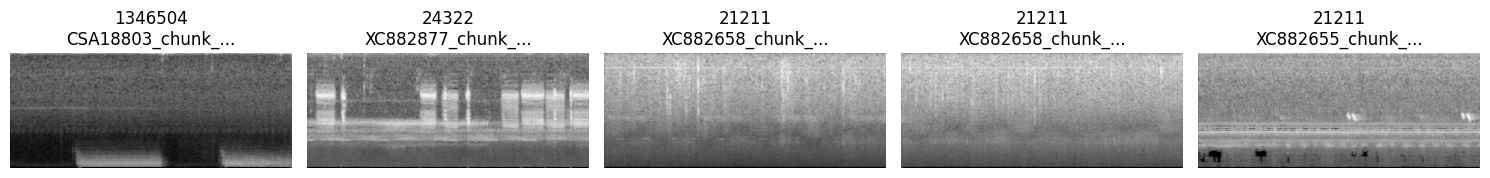

In [4]:
def visualize_spectrograms(n_samples=5):
    """
    Visualize a random selection of spectrograms from the processed data.

    Args:
        n_samples: Number of spectrograms to display
    """
    # Find all .npy files in the specs directory
    spec_files = []
    for root, _, files in os.walk(Config.specs_output_dir):
        for file in files:
            if file.endswith(".npy"):
                spec_files.append(os.path.join(root, file))

    if not spec_files:
        print("No spectrograms found.")
        return

    # Select random samples
    import random

    samples = random.sample(spec_files, min(n_samples, len(spec_files)))

    # Set up the plot
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 4))
    if len(samples) == 1:
        axes = [axes]

    # Plot each spectrogram
    for i, spec_file in enumerate(samples):
        # Load the spectrogram
        spec = np.load(spec_file)

        # Get class name from directory structure
        class_name = os.path.basename(os.path.dirname(spec_file))

        # Get file basename
        file_basename = os.path.basename(spec_file)

        # Display the spectrogram
        axes[i].imshow(spec)
        axes[i].set_title(f"{class_name}\n{file_basename[:15]}...")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# For visualizing a single spectrogram in more detail
def visualize_single_spectrogram(spec_file):
    """
    Visualize a single spectrogram with more detail

    Args:
        spec_file: Path to the .npy file containing the spectrogram
    """
    # Load the spectrogram
    spec = np.load(spec_file)

    # Get class name and file basename
    class_name = os.path.basename(os.path.dirname(spec_file))
    file_basename = os.path.basename(spec_file)

    # Plot with time and frequency axes
    plt.figure(figsize=(10, 6))
    plt.imshow(spec[:, :, 0], aspect="auto", origin="lower")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram: {class_name} - {file_basename}")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.tight_layout()
    plt.show()


# Find a specific class to visualize
def visualize_class_spectrograms(class_name, n_samples=5):
    """
    Visualize spectrograms from a specific bird class

    Args:
        class_name: Name of the bird class to visualize
        n_samples: Number of spectrograms to display
    """
    # Find all .npy files for this class
    class_dir = os.path.join(Config.specs_output_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"No directory found for class: {class_name}")
        return

    spec_files = glob(os.path.join(class_dir, "*.npy"))

    if not spec_files:
        print(f"No spectrograms found for class: {class_name}")
        return

    # Select random samples
    import random

    samples = random.sample(spec_files, min(n_samples, len(spec_files)))

    # Set up the plot
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 4))
    if len(samples) == 1:
        axes = [axes]

    # Plot each spectrogram
    for i, spec_file in enumerate(samples):
        # Load the spectrogram
        spec = np.load(spec_file)

        # Get file basename
        file_basename = os.path.basename(spec_file)

        # Display the spectrogram
        axes[i].imshow(spec)
        axes[i].set_title(f"{file_basename[:15]}...")
        axes[i].axis("off")

    plt.suptitle(f"Spectrograms for {class_name}")
    plt.tight_layout()
    plt.show()


# Example usage:
print("Visualizing random spectrograms:")
visualize_spectrograms(5)

# Uncomment to visualize spectrograms from a specific class
# Available classes (example - replace with actual class names from your dataset):
# bird_classes = os.listdir(Config.specs_output_dir)
# print(f"Available bird classes: {bird_classes}")
# visualize_class_spectrograms(bird_classes[0], 3)